# Main imports

### Native imports

In [1]:
import os
import pandas as pd
from datetime import date, datetime

### More imports

In [2]:
import matplotlib.pyplot as plt

from sklearn.utils import shuffle

from tensorflow import keras

from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential

from keras.layers import Dense, Activation, Dropout, Conv2D, MaxPooling2D, Flatten, ZeroPadding2D, BatchNormalization

from keras.regularizers import l2
 
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Load imatge classification

En un futur seria interesant crear una llibreria propia per a manejar les dades i poder agafar mostres en concret. En aquest cas estic agafant la part de validation perque conte totes les cares d'una mateix persona i per a fer proves i entrenar la xarxa és més ràpid.

In [4]:
from data_explorer import get_celebrities
identity_df = get_celebrities(5)
identity_df

,Image_name,Identity
1552,001553.jpg,2820
2278,002279.jpg,3745
2557,002558.jpg,2820
3567,003568.jpg,2820
3646,003647.jpg,3745
...,...,...
180889,180890.jpg,3782
181299,181300.jpg,3782
181835,181836.jpg,3227
182154,182155.jpg,3782


## Process data

In [83]:
TARGET = 3227

In [84]:
identity_df["target"] = identity_df["Identity"] == TARGET
identity_df["target"] = identity_df["target"].astype(str)

### Training, validation and test dataframes

In [85]:
train_df = identity_df[identity_df["Evaluation_status"] == 0][["target","Image_name"]]
val_df = identity_df[identity_df["Evaluation_status"] == 1][["target","Image_name", "Identity"]]
test_df = identity_df[identity_df["Evaluation_status"] == 2][["target","Image_name"]]

### Cleaning data

In [86]:
train_df = train_df.iloc[:161679]
val_df = val_df.loc[163291:181835]
val_df = val_df[~val_df["Identity"].isin([1642, 1807, 1625, 1934, 3140, 1519, 2496, 1542, 1164, 2973, 1440, 1908, 2195, 2303, 499, 4388, 3113, 3255, 981])]
val_df = shuffle(val_df)
val_df.reset_index(inplace=True)
val_df
print(val_df["target"].value_counts())

False    17940
True        35
Name: target, dtype: int64


In [87]:
def print_params_tvt(train_df, val_df, test_df):
    print(f"Train len: {len(train_df)}")
    print(train_df["target"].nunique())
    print(f"Val len: {len(val_df)}")
    print(val_df["target"].nunique())
    print(f"Test len: {len(test_df)}")
    print(test_df["target"].nunique())

In [88]:
print_params_tvt(train_df, val_df, test_df)

Train len: 161679
1
Val len: 17975
2
Test len: 19962
1


In [89]:
train = val_df.iloc[:-2980*2]
val = val_df.iloc[-2980*2:-2980]
test = val_df.iloc[-2980:]
print_params_tvt(train, val, test)

Train len: 12015
2
Val len: 2980
2
Test len: 2980
2


In [90]:
img_dir = "Imatges/CelebA/Img/img_align_celeba/img_align_celeba/"
img_size = (178,218)
batch_size = 100
epochs = 25

In [91]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale = 1/255.0)

In [92]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory=img_dir,
    x_col="Image_name",
    y_col="target",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary")

valid_generator = train_datagen.flow_from_dataframe(
    dataframe=val,
    directory=img_dir,
    x_col="Image_name",
    y_col="target",
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary")

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test,
    directory=img_dir,
    x_col="Image_name",
    target_size=img_size,
    batch_size=1,
    class_mode=None,
    shuffle=True,
)

Found 12015 validated image filenames belonging to 2 classes.
Found 2980 validated image filenames belonging to 2 classes.
Found 2980 validated image filenames.


In [93]:
# model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-06, mode=0)) el mode=0 dona un error ja que es d'una versio anterior.
# He intentat buscar a quin argument correspon per actualitzar la funcio pero no he trobat cap
def prepare_model2():
    model = Sequential()
    model.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape=(178, 218, 3), 
                        kernel_initializer='glorot_uniform', data_format='channels_last'))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-06))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))    
    model.add(ZeroPadding2D((2, 2), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last'))
    model.add(BatchNormalization(axis=1, momentum=0.9, epsilon=1e-06))
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))# added extra
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform',  data_format='channels_last'))
    model.add(ZeroPadding2D((1, 1), data_format='channels_last'))
    
    model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format='channels_last'))    
    model.add(MaxPooling2D((3,3), strides=(2, 2)))
    model.add(Dropout(0.3))# added extra
    model.add(Flatten(name='flatten'))
    model.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    model.add(Dropout(0.5))
    
    model.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    model.compile(loss="binary_crossentropy",optimizer="adam")
    model.summary()
    return model



In [94]:
# https://github.com/hlamba28/Offline-Signature-Verification-using-Siamese-Network/blob/master/SigNet-BHSig260.ipynb
# Using Keras Callbacks, save the model after every epoch
# Reduce the learning rate by a factor of 0.1 if the validation loss does not improve for 5 epochs
# Stop the training using early stopping if the validation loss does not improve for 12 epochs
callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('./Weights/weights_epoch_{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [95]:
model = prepare_model2()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1_1 (Conv2D)            (None, 42, 52, 96)        34944     
                                                                 
 batch_normalization_4 (Batc  (None, 42, 52, 96)       168       
 hNormalization)                                                 
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 20, 25, 96)       0         
 2D)                                                             
                                                                 
 zero_padding2d_6 (ZeroPaddi  (None, 24, 29, 96)       0         
 ng2D)                                                           
                                                                 
 conv2_1 (Conv2D)            (None, 20, 25, 256)       614656    
                                                      

In [96]:
history = model.fit(train_generator,
                    validation_data = valid_generator,
                    steps_per_epoch = train_generator.n//train_generator.batch_size,
                    validation_steps = valid_generator.n//valid_generator.batch_size,
                    epochs=epochs,
                    callbacks = callbacks)


Epoch 1/25
 36/120 [========>.....................] - ETA: 6:43 - loss: 1.3193

KeyboardInterrupt: 

In [ ]:
score = model.evaluate(valid_generator)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

47/47 [==============================] - 30s 635ms/step - loss: 0.0102 - accuracy: 0.9983
Test loss: 0.010179730132222176
Test accuracy: 0.9983221292495728


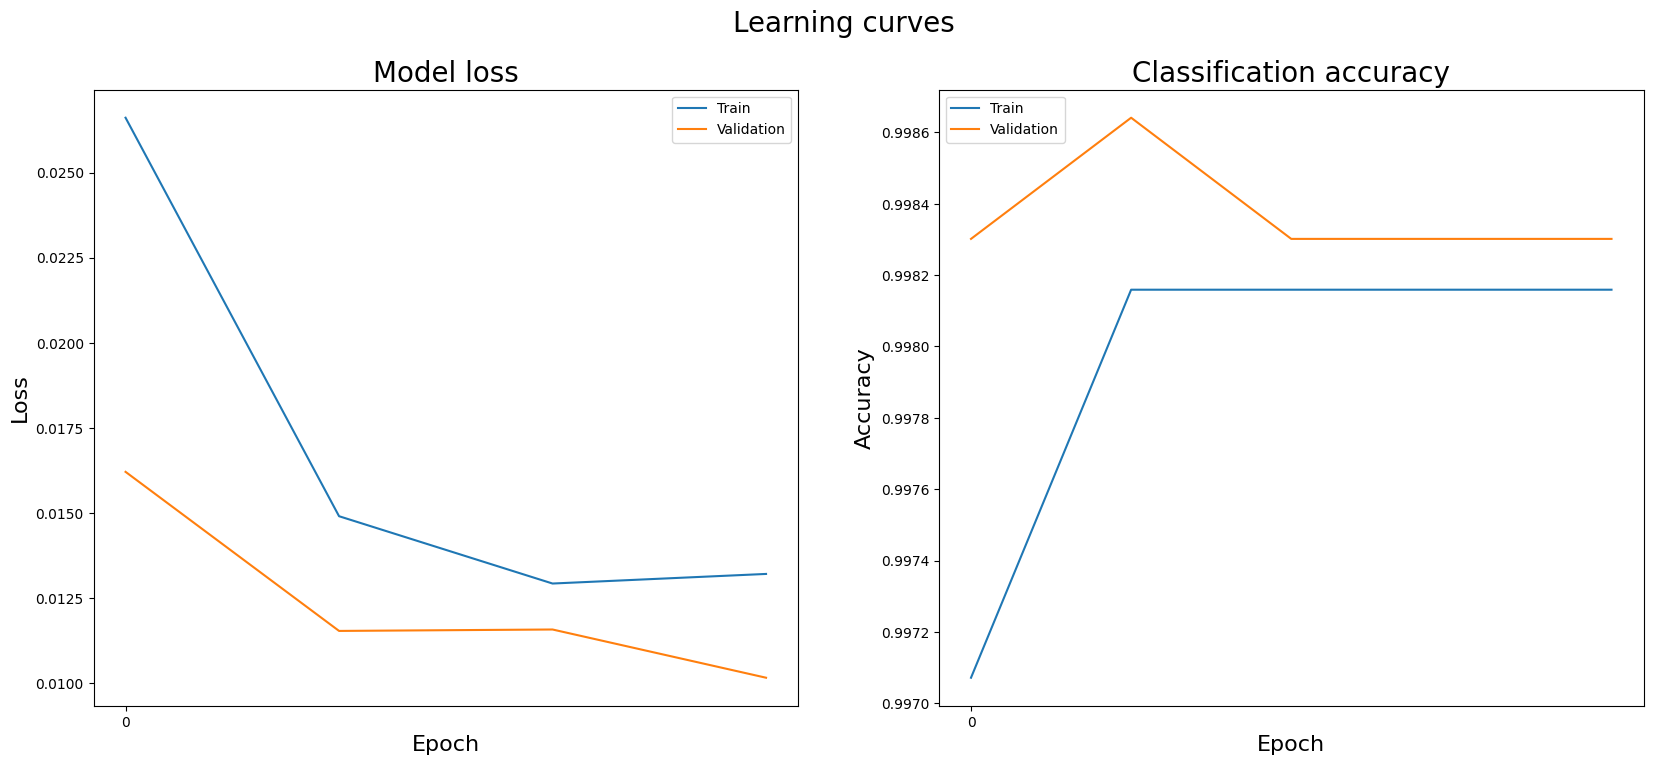

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize = (20, 8))

ax1.plot(history.history['loss'][1:])
ax1.plot(history.history['val_loss'][1:])
ax1.set_title('Model loss', size=20)
ax1.set_ylabel('Loss', size=16)
ax1.set_xlabel('Epoch', size=16)
ax1.set_xticks(range(0, epochs+1, 25))
ax1.legend(['Train', 'Validation'], loc='upper right')

ax2.plot(history.history['accuracy'])
ax2.plot(history.history['val_accuracy'])
ax2.set_title('Classification accuracy', size=20)
ax2.set_ylabel('Accuracy', size=16)
ax2.set_xlabel('Epoch', size=16)
ax2.set_xticks(range(0, epochs+1, 25))
ax2.legend(['Train', 'Validation'], loc='upper left')

fig.suptitle('Learning curves', size=20)

plt.show()